# Explore SDSS table
This jupyter notebook is used to visualize the initial SDSS table queried for the project and select the SDSS-affiliated emission line catalog used in the rest of the analysis

## Imports

In [8]:
import numpy as np
from astropy.io import fits, ascii
import astropy.units as u
from astropy.table import Table
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import sys 
import cmocean as cmo

%matplotlib inline

## Custom functions

In [9]:
def O32_I18(O3_5007,O2_3727):
  # Definition given in Izotov et al. 2018
  return(O3_5007/O2_3727) 

def O32_F22(O3_5007,O2_3726,O2_3729):
  # Definition given in Flury et al. 2022
  return(O3_5007/(O2_3726+O2_3729)) 

def O32_P22(O3_4959,O3_5008,O2_3726,O2_3729):
  # Definition given in Papovich et al. 2022
  return((O3_4959+O3_5008)/(O2_3726+O2_3729)) 

## Specify paths

In [3]:
data_p = './data/'
fig_g = './figures/'
table_p = data_p + 'SDSS_DR17_Matched_Information.csv'

### Open table

In [4]:
t = ascii.read(table_p, format='basic', delimiter=',', guess=False) 

In [5]:
t

modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,ra,dec,z,ObjID,mode,type,clean,specObjID,Flux_OIII_4958,Flux_OIII_4958_Err,FLux_OIII_5006,FLux_OIII_5006_Err,Flux_OII_3726,Flux_OII_3726_Err,Flux_OII_3728,Flux_OII_3728_Err,oiii_4959_flux,oiii_4959_flux_err,oiii_5007_flux,oiii_5007_flux_err,oii_3729_flux,oii_3729_flux_err,oii_3726_flux,oii_3726_flux_err,logMass,metallicity,age,ssfr,Column1,minlogMass,maxLogMass,SFR,minSFR,maxSFR,Column2
float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
19.66839,17.83619,17.16956,16.85131,16.58468,229.93279562063,7.75436168434739,0.03462818,1237662197747745131,1,3,0,2047001555512616960,3.343236,1.775974,9.552102,5.074212,22.83752,13.69908,45.56644,58.61165,1.664851,1.426862,2.987941,1.42633,-1.424089,3.617231,10.79702,3.907149,9.33945931376284,0.00769999995827675,2.00088047981262,-1.58499908447266,9.06,8.87,9.14,0.0,0.0,0.0,0.02
18.42497,16.46613,15.56528,15.14275,14.7951,229.956827905323,7.81281151181592,0.0425399,1237662197747745143,1,3,1,2046998256977733632,15.1694,5.202966,43.34115,14.86562,162.7156,8668.07,83.20232,12623.88,2.195039,3.944313,20.52398,4.17063,8.500624,6.295256,23.5517,6.658473,10.6245435100394,0.00769999995827675,3.41003704071045,-3.35963487625122,10.49,10.44,10.82,0.0,0.0,0.1,0.04
19.71043,18.22356,17.81454,17.50066,17.28146,229.950281422335,7.84153461068372,0.07584161,1237662197747745333,1,3,1,2047001005756803072,11.0033,2.11554,31.43801,6.044399,197.2308,148.4198,17.05398,115.0141,4.419672,1.679445,16.5639,1.836277,37.6798,3.494535,39.19313,3.567269,9.80223509512311,0.0120000001043081,1.30688512325287,-0.292811244726181,9.28,9.22,9.36,0.0,0.0,0.0,0.02
18.42605,16.77179,15.95624,15.55291,15.22884,230.020449266655,7.8249640540335,0.04858921,1237662197747810509,1,3,1,2047008977216104448,2.54,3.480551,7.257142,9.944433,32.70702,14.09445,28.81954,14.82691,4.886132,3.886356,8.983654,3.882987,14.52591,6.793278,16.43024,7.012192,10.527184246644,0.00769999995827675,3.50055408477783,-1.64312648773193,10.3,9.87,10.3,0.5,0.0,0.5,0.04
18.32344,16.41611,15.56927,15.17142,14.83763,230.073850709502,7.73458849981151,0.04826854,1237662197747810581,1,3,1,2047010626483546112,19.41872,22.97698,55.48206,65.64853,18.42138,24.8859,63.67159,96.90556,-2.144605,4.111876,-1.197808,4.011215,4.013726,7.089595,-7.487408,6.840191,10.6211549418894,0.00769999995827675,2.30776882171631,-4.74274015426636,10.48,10.4,10.82,0.0,0.0,0.0,0.04
20.73911,18.42975,17.50149,17.0666,16.73239,230.110547652294,7.82004883745322,0.0762452,1237662197747810603,1,3,1,2047008152582383616,0.0,0.0,0.0,0.0,8.268576,20.80894,16.34139,15.42571,3.619494,1.985199,-2.839154,1.861846,4.066424,2.781724,1.334813,2.838022,10.3769709720301,0.00769999995827675,2.83135485649109,-3.42206788063049,10.49,10.4,10.6,0.0,0.0,0.0,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18.29279,16.8465,16.20786,15.89794,15.70379,229.614629793276,7.83878206463974,0.03372938,1237662197747613931,1,3,1,2046985612594014208,3.350321,2.200013,9.572346,6.285753,19.72684,17.95431,21.97523,23.39261,1.833333,2.204904,6.432841,2.224961,8.564864,5.033955,8.400452,5.220498,9.70862850163361,0.00769999995827675,2.08578443527222,-1.98188626766205,9.63,9.32,9.86,0.0,0.0,0.1,0.004
21.11863,18.69781,17.69698,17.27105,16.89118,229.807531886745,7.8516622153929,0.10457,1237662197747679369,1,3,0,2046999631367268352,2.329161,2.066753,6.654746,5.905009,18.61704,7.320421,15.79375,11.52458,4.455527,3.481916,11.62489,3.613415,20.79266,8.512793,6.115491,8.405254,10.5632944519867,0.0299999993294477,2.24202561378479,-3.40829801559448,10.74,10.64,10.87,0.0,0.0,0.0,0.04


## Look at properties

Properties in the table were queried from tables listed here:  
https://skyserver.sdss.org/dr18/MoreTools/browser/#  
Specifically emissionLinesPort, Galspecline and stellarMassStarformingPort  


### Generic galaxy properties

We start by removing galaxies with clean=0

In [6]:
t = t[t['clean'] == 1]

### [OIII] and [OII] line properties

#### emissionlinesport

In [7]:
O3_4958_elp = t['Flux_OIII_4958'] *1e-17 *u.erg/u.cm/u.cm/u.s
O3_4958_err_elp = t['Flux_OIII_4958_Err'] *1e-17 *u.erg/u.cm/u.cm/u.s
snr_O3_4958_elp = O3_4958_elp/O3_4958_err_elp 
O3_5006_elp = t['FLux_OIII_5006'] *1e-17 *u.erg/u.cm/u.cm/u.s
O3_5006_err_elp = t['FLux_OIII_5006_Err'] *1e-17 *u.erg/u.cm/u.cm/u.s
snr_O3_5006_elp = O3_5006_elp/O3_5006_err_elp 
O2_3726_elp = t['Flux_OII_3726'] *1e-17 *u.erg/u.cm/u.cm/u.s
O2_3726_err_elp = t['Flux_OII_3726_Err'] *1e-17 *u.erg/u.cm/u.cm/u.s
snr_O2_3726_elp = O2_3726_elp/O2_3726_err_elp 
O2_3728_elp = t['Flux_OII_3728'] *1e-17 *u.erg/u.cm/u.cm/u.s
O2_3728_err_elp = t['Flux_OII_3728_Err'] *1e-17 *u.erg/u.cm/u.cm/u.s
snr_O2_3728_elp = O2_3728_elp/O2_3728_err_elp 

/Users/alereste/anaconda3/envs/O32_merg/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/alereste/anaconda3/envs/O32_merg/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


##### Implementing cleaning criteria

In [8]:
snr_thresh = 3.0
snr_crit_elp = (snr_O3_4958_elp>snr_thresh) & (snr_O3_5006_elp>snr_thresh)  & (snr_O2_3726_elp>snr_thresh) & (snr_O2_3728_elp>snr_thresh)
nonzeropos_crit_elp = (O3_4958_elp>0) & (O3_5006_elp>0) & (O2_3726_elp>0) & (O2_3728_elp>0)
total_crit_elp = snr_crit_elp & nonzeropos_crit_elp

In [9]:
print("Initial number of galaxies in the sample:", len(snr_O3_4958_elp))
print("Number of galaxies in the sample with SNR criterion in emissionlinesport:", np.count_nonzero(snr_crit_elp))
print("Number of galaxies in the sample with nonzero positive criterion in emissionlinesport:", np.count_nonzero(nonzeropos_crit_elp ))
print("Number of galaxies in the sample with all criteria in emissionlinesport:", np.count_nonzero(total_crit_elp))

Initial number of galaxies in the sample: 747921
Number of galaxies in the sample with SNR criterion in emissionlinesport: 70126
Number of galaxies in the sample with nonzero positive criterion in emissionlinesport: 528071
Number of galaxies in the sample with all criteria in emissionlinesport: 70126


In [10]:
O3_4958_elp = np.where(snr_crit_elp==True,O3_4958_elp,np.nan)
O3_4958_err_elp = np.where(snr_crit_elp==True,O3_4958_err_elp,np.nan)
snr_O3_4958_elp = np.where(snr_crit_elp==True,snr_O3_4958_elp,np.nan)
O3_5006_elp = np.where(snr_crit_elp==True,O3_5006_elp,np.nan)
O3_5006_err_elp = np.where(snr_crit_elp==True,O3_5006_err_elp,np.nan)
snr_O3_5006_elp = np.where(snr_crit_elp==True,snr_O3_5006_elp,np.nan)
O2_3726_elp = np.where(snr_crit_elp==True,O2_3726_elp,np.nan)
O2_3726_err_elp = np.where(snr_crit_elp==True,O2_3726_err_elp,np.nan)
snr_O2_3726_elp = np.where(snr_crit_elp==True,snr_O2_3726_elp,np.nan)
O2_3728_elp = np.where(snr_crit_elp==True,O2_3728_elp,np.nan)
O2_3728_err_elp = np.where(snr_crit_elp==True,O2_3728_err_elp,np.nan)
snr_O2_3728_elp = np.where(snr_crit_elp==True,snr_O2_3728_elp,np.nan)

##### O32 ratio

In [11]:
O32_I18_elp = O32_I18(O3_5006_elp,O2_3726_elp)
logO32_I18_elp = np.log10(O32_I18_elp)
logO32_I18_elp_h = np.where(np.isinf(logO32_I18_elp),np.nan,logO32_I18_elp)
O32_F22_elp = O32_F22(O3_5006_elp,O2_3726_elp,O2_3728_elp)
logO32_F22_elp = np.log10(O32_F22_elp)
logO32_F22_elp_h = np.where(np.isinf(logO32_F22_elp),np.nan,logO32_F22_elp)
O32_P22_elp = O32_P22(O3_4958_elp,O3_5006_elp,O2_3726_elp,O2_3728_elp)
logO32_P22_elp = np.log10(O32_P22_elp)
logO32_P22_elp_h = np.where(np.isinf(logO32_P22_elp),np.nan,logO32_P22_elp)


##### Plotting sample values

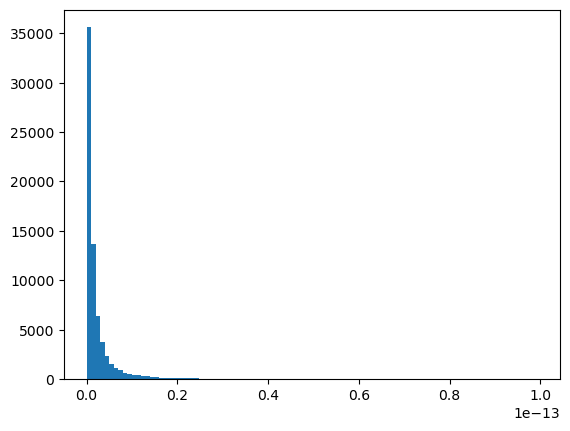

In [12]:
plt.figure()
plt.hist(O3_5006_elp[(O3_5006_elp>0)&(O3_5006_elp.value<1e-13)] ,100)
plt.show()

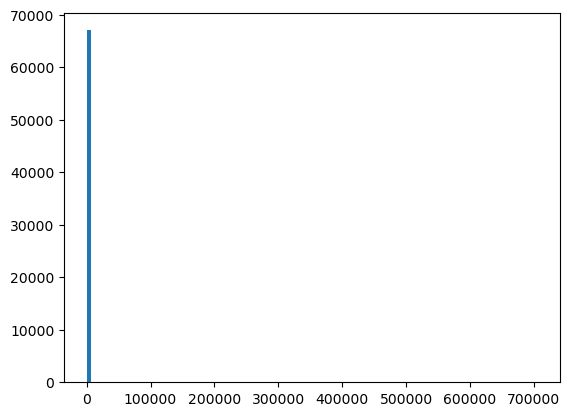

In [13]:
plt.figure()
plt.hist(np.where(np.isinf(snr_O3_4958_elp),np.nan,snr_O3_4958_elp) ,100)
plt.show()

In [14]:
np.nanmedian(snr_O3_4958_elp)

<Quantity 10.85508609>

In [15]:
np.nanmax(O3_5006_elp)

<Quantity 2.154507e+17 erg / (s cm2)>

In [16]:
O3_5006_elp

<Quantity [nan, nan, nan, ..., nan, nan, nan] erg / (s cm2)>

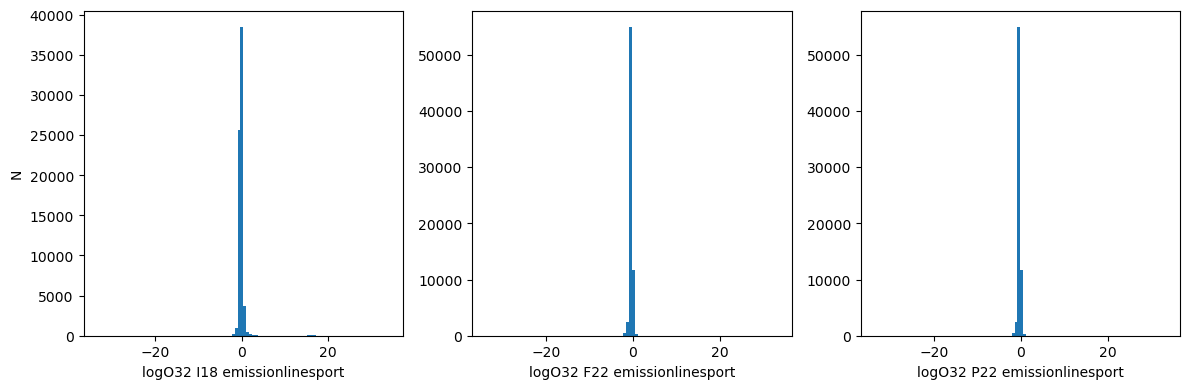

In [17]:
fig = plt.figure(figsize=(3*4,1*4))

ax0 = fig.add_subplot(1, 3, 1)
ax0.hist(logO32_I18_elp_h,100 )
ax0.set_xlabel('logO32 I18 emissionlinesport')
ax0.set_ylabel('N')

ax1 = fig.add_subplot(1, 3, 2)
ax1.hist(logO32_F22_elp_h,100 )
ax1.set_xlabel('logO32 F22 emissionlinesport')

ax2 = fig.add_subplot(1, 3, 3)
ax2.hist(logO32_P22_elp_h,100 )
ax2.set_xlabel('logO32 P22 emissionlinesport')

plt.tight_layout()
plt.show()

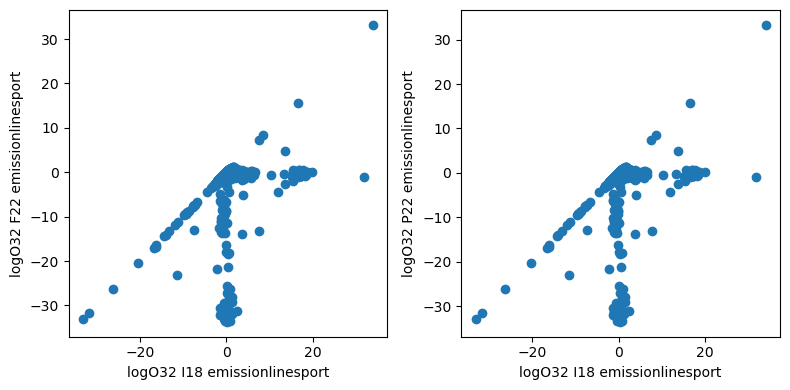

In [18]:
fig = plt.figure(figsize=(2*4,1*4))

ax0 = fig.add_subplot(1, 2, 1)
ax0.scatter(logO32_I18_elp,logO32_F22_elp)
ax0.set_xlabel('logO32 I18 emissionlinesport')
ax0.set_ylabel('logO32 F22 emissionlinesport')

ax1 = fig.add_subplot(1, 2, 2)
ax1.scatter(logO32_I18_elp,logO32_P22_elp)
ax1.set_xlabel('logO32 I18 emissionlinesport')
ax1.set_ylabel('logO32 P22 emissionlinesport')

plt.tight_layout()
plt.show()


### Galspecline

In [19]:
O3_4959_gsl = t['oiii_4959_flux'] *1e-17 *u.erg/u.cm/u.cm/u.s 
O3_4959_err_gsl = t['oiii_4959_flux_err'] *1e-17 *u.erg/u.cm/u.cm/u.s 
snr_O3_4958_gsl= O3_4959_gsl/O3_4959_err_gsl
O3_5007_gsl = t['oiii_5007_flux'] *1e-17 *u.erg/u.cm/u.cm/u.s
O3_5007_err_gsl = t['oiii_5007_flux_err'] *1e-17 *u.erg/u.cm/u.cm/u.s
snr_O3_5007_gsl = O3_5007_gsl/O3_5007_err_gsl
O2_3726_gsl = t['oii_3726_flux'] *1e-17 *u.erg/u.cm/u.cm/u.s
O2_3726_err_gsl = t['oii_3726_flux_err'] *1e-17 *u.erg/u.cm/u.cm/u.s 
snr_O2_3726_gsl = O2_3726_gsl/O2_3726_err_gsl
O2_3729_gsl = t['oii_3729_flux'] *1e-17 *u.erg/u.cm/u.cm/u.s
O2_3729_err_gsl = t['oii_3729_flux_err'] *1e-17 *u.erg/u.cm/u.cm/u.s 
snr_O2_3729_gsl = O2_3729_gsl/O2_3729_err_gsl

##### Implementing cleaning criteria

In [20]:
snr_thresh = 3.0
snr_crit_gsl = (snr_O3_4958_gsl>snr_thresh) & (snr_O3_5007_gsl>snr_thresh)  & (snr_O2_3726_gsl>snr_thresh) & (snr_O2_3729_gsl>snr_thresh)
nonzeropos_crit_gsl = (O3_4959_gsl >0) & (O3_5007_gsl>0) & (O2_3726_gsl>0) & (O2_3729_gsl>0)
total_crit_gsl = snr_crit_gsl & nonzeropos_crit_gsl

In [21]:
print("Initial number of galaxies in the sample:", len(snr_O3_4958_gsl))
print("Number of galaxies in the sample with SNR criterion in emissionlinesport:", np.count_nonzero(snr_crit_gsl ))
print("Number of galaxies in the sample with nonzero positive criterion in emissionlinesport:", np.count_nonzero(nonzeropos_crit_gsl))
print("Number of galaxies in the sample with all criteria in emissionlinesport:", np.count_nonzero(total_crit_gsl))

Initial number of galaxies in the sample: 747921
Number of galaxies in the sample with SNR criterion in emissionlinesport: 143560
Number of galaxies in the sample with nonzero positive criterion in emissionlinesport: 429543
Number of galaxies in the sample with all criteria in emissionlinesport: 143560


In [22]:
O3_4959_gsl = np.where(snr_crit_gsl==True,O3_4959_gsl,np.nan)
O3_4959_err_gsl = np.where(snr_crit_gsl==True,O3_4959_err_gsl,np.nan)
snr_O3_4958_gsl = np.where(snr_crit_gsl==True,snr_O3_4958_gsl,np.nan)
O3_5007_gsl = np.where(snr_crit_gsl==True,O3_5007_gsl,np.nan)
O3_5007_err_gsl = np.where(snr_crit_gsl==True,O3_5007_err_gsl ,np.nan)
snr_O3_5007_gsl = np.where(snr_crit_gsl==True,snr_O3_5007_gsl ,np.nan)
O2_3726_gsl = np.where(snr_crit_gsl==True,O2_3726_gsl,np.nan)
O2_3726_err_gsl = np.where(snr_crit_gsl==True,O2_3726_err_gsl,np.nan)
snr_O2_3726_gsl = np.where(snr_crit_gsl==True,snr_O2_3726_gsl,np.nan)
O2_3729_gsl = np.where(snr_crit_gsl==True,O2_3729_gsl ,np.nan)
O2_3729_err_gsl = np.where(snr_crit_gsl==True,O2_3729_gsl ,np.nan) 
snr_O2_3729_gsl = np.where(snr_crit_gsl==True,snr_O2_3729_gsl,np.nan)

##### O32 ratio

In [23]:
O32_I18_gsl = O32_I18(O3_5007_gsl,O2_3726_gsl)
logO32_I18_gsl = np.log10(O32_I18_gsl)
logO32_I18_gsl_h = np.where(np.isinf(logO32_I18_gsl),np.nan,logO32_I18_gsl)
O32_F22_gsl = O32_F22(O3_5007_gsl,O2_3726_gsl,O2_3729_gsl)
logO32_F22_gsl = np.log10(O32_F22_gsl)
logO32_F22_gsl_h = np.where(np.isinf(logO32_F22_gsl),np.nan,logO32_F22_gsl)
O32_P22_gsl = O32_P22(O3_4959_gsl,O3_5007_gsl,O2_3726_gsl,O2_3729_gsl)
logO32_P22_gsl = np.log10(O32_P22_gsl)
logO32_P22_gsl_h = np.where(np.isinf(logO32_P22_gsl),np.nan,logO32_P22_gsl)


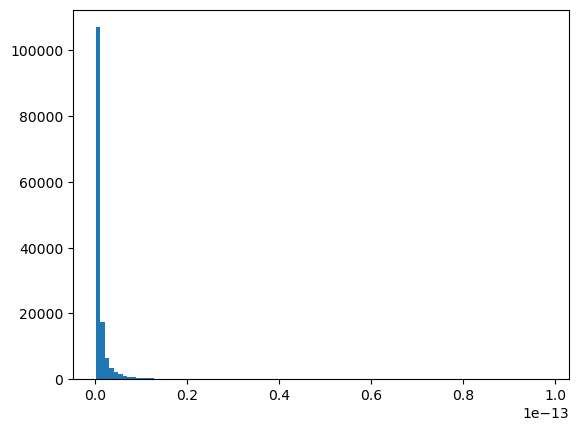

In [24]:
plt.figure()
plt.hist(O3_5007_gsl[(O3_5007_gsl>0)&(O3_5007_gsl.value<1e-13)] ,100 )
plt.show()

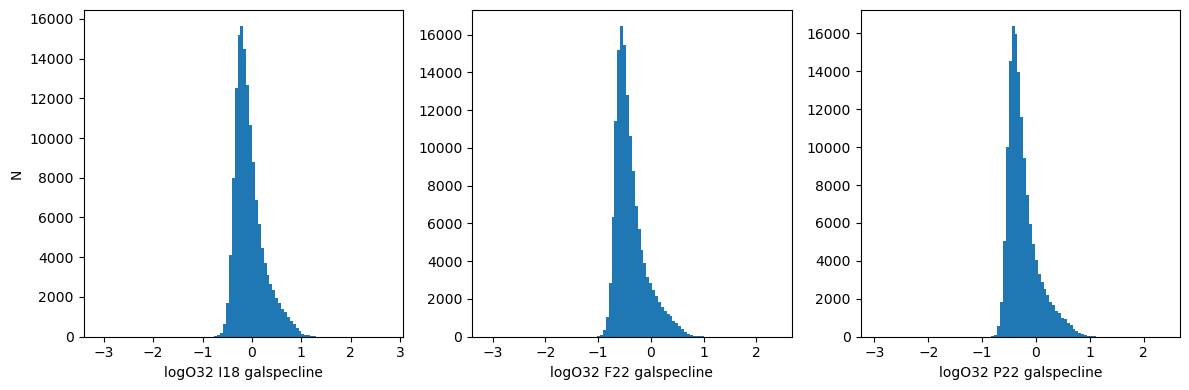

In [25]:
fig = plt.figure(figsize=(3*4,1*4))

ax0 = fig.add_subplot(1, 3, 1)
ax0.hist(logO32_I18_gsl_h,100 )
ax0.set_xlabel('logO32 I18 galspecline')
ax0.set_ylabel('N')

ax1 = fig.add_subplot(1, 3, 2)
ax1.hist(logO32_F22_gsl_h,100 )
ax1.set_xlabel('logO32 F22 galspecline')

ax2 = fig.add_subplot(1, 3, 3)
ax2.hist(logO32_P22_gsl_h,100 )
ax2.set_xlabel('logO32 P22 galspecline')

plt.tight_layout()
plt.show()

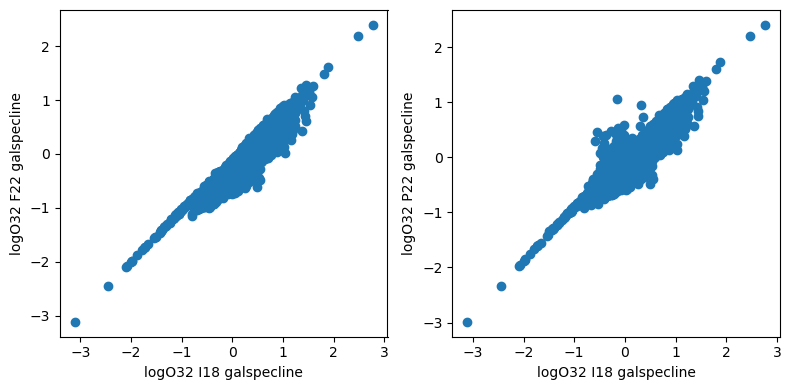

In [26]:
fig = plt.figure(figsize=(2*4,1*4))

ax0 = fig.add_subplot(1, 2, 1)
ax0.scatter(logO32_I18_gsl,logO32_F22_gsl)
ax0.set_xlabel('logO32 I18 galspecline')
ax0.set_ylabel('logO32 F22 galspecline')

ax1 = fig.add_subplot(1, 2, 2)
ax1.scatter(logO32_I18_gsl,logO32_P22_gsl)
ax1.set_xlabel('logO32 I18 galspecline')
ax1.set_ylabel('logO32 P22 galspecline')

plt.tight_layout()
plt.show()


## Catalog choice

emissionlinesport returns a smaller sample with valid SNR thresholds, and the O32 values using different methods are sometimes very discrepant. In comparison, galspeclines returns a large sampe of galaxies with valid line properties and O32 values are in relative agreement. In the following we will thus use the galspeclines catalog for line emission properties.